# Simple Spread
**Objectives**: The environment has N agents and N landmarks. Agents must learn to cover all the landmarks while avoiding collisions. All agents are globally rewarded based on how far the closest agents is to each landmark (sum of the minimum distances). The agents are penalised if they collide with other agents (-1 for each collision).

**Actions**:
 - Agent observations: `[self_vel, self_pos, landmark_rel_positions, other_agent_rel_positions, communication]`
 - Agent action space: `[no_action, move_left, move_right, move_down, move_up]`

In [435]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gymnasium as gym
import numpy as np
import torch
from pettingzoo.mpe import simple_spread_v3
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, RandomPolicy, DQNPolicy, MultiAgentPolicyManager
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net

import pygame
import imageio
import matplotlib.pyplot as plt

In [442]:
# we train for the case N=3
num_agents=3

We apply Random Policy to each of the agents.

In [17]:
# Initialize Pygame
pygame.init()

# Set up Pygame window and clock
width, height = 800, 800
screen = pygame.display.set_mode((width, height))
clock = pygame.time.Clock()

# Your Pygame application logic goes here
test_env = simple_spread_v3.env(N=num_agents, max_cycles=50, local_ratio=0.5, continuous_actions=False,render_mode="human")
test_env.reset(seed=42)
test_env = PettingZooEnv(test_env)
random_policy = RandomPolicy(test_env.observation_space, test_env.action_space)
policy = MultiAgentPolicyManager([random_policy, random_policy, random_policy], test_env)
test_env = DummyVectorEnv([lambda: test_env])
collector = Collector(policy, test_env)

# Specify the path to save the GIF
output_gif_path = "random.gif"

# Set the number of frames to capture
num_frames = 50

# Create an ImageIO writer
imageio_writer = imageio.get_writer(output_gif_path, duration=0.5)

# Collect frames and save as a GIF
for _ in range(num_frames):
    # Collect a step
    result = collector.collect(n_step=3, render=0.1)

    # Capture the Pygame window as an image
    pygame_screen = pygame.display.get_surface()
    pygame_surface = pygame.surfarray.array3d(pygame_screen)
    imageio_frame = pygame.surfarray.make_surface(pygame_surface).convert_alpha()

    # Append the frame to the ImageIO writer
    imageio_writer.append_data(pygame.surfarray.array3d(imageio_frame))

    # Update the Pygame display
    pygame.display.flip()

    # Control the frame rate
    clock.tick(10)

# Close the ImageIO writer
imageio_writer.close()

# Quit Pygame
pygame.quit()

In [25]:
mean_reward = []
for _ in range(100):  
    test_env = simple_spread_v3.env(N=num_agents, max_cycles=50, local_ratio=0.5, continuous_actions=False,render_mode="human")
    test_env.reset(seed=42)
    test_env = PettingZooEnv(test_env)
    random_policy = RandomPolicy(test_env.observation_space, test_env.action_space)
    policy = MultiAgentPolicyManager([random_policy, random_policy, random_policy], test_env)
    test_env = DummyVectorEnv([lambda: test_env])
    collector = Collector(policy, test_env)
    result = collector.collect(n_episode=1, render=0.01)
    mean_reward.append(result["rews"].mean())

In [29]:
# mean reward averaged over 100 episodes
sum(mean_reward)/100

-62.08552250741849

In [399]:
def get_env(render_mode=None):
    """This functions is needed to provide callables for DummyVectorEnv"""
    return PettingZooEnv(simple_spread_v3.env(N=num_agents, max_cycles=50, local_ratio=0.5, continuous_actions=False,
                                              render_mode="rgb_array"))

In [400]:
def get_parser() -> argparse.ArgumentParser:
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=1626)
    parser.add_argument('--eps-test', type=float, default=0)
    parser.add_argument('--eps-train-start', type=float, default=1)
    parser.add_argument('--eps-train-final', type=float, default=0.01)
    parser.add_argument('--eps-decay', type=float, default=1e-6)
    parser.add_argument('--buffer-size', type=int, default=20000)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--gamma', type=float, default=0.99, help='a smaller gamma favors earlier win')
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--target-update-freq', type=int, default=320)
    parser.add_argument('--epoch', type=int, default=50)
    parser.add_argument('--step-per-epoch', type=int, default=9600)
    parser.add_argument('--step-per-collect', type=int, default=10)
    parser.add_argument('--update-per-step', type=float, default=0.1)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--hidden-sizes', type=int, nargs='*', default=[128, 128, 128, 128])
    parser.add_argument('--training-num', type=int, default=64)
    parser.add_argument('--test-num', type=int, default=10)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.1)
    parser.add_argument('--win-rate', type=float, default=0)
    parser.add_argument('--watch', default=False, action='store_true', help='no training, watch the play of pre-trained models')
    parser.add_argument('--agent-id', type=int, default=2)
    parser.add_argument('--resume-path-0', type=str, default='', help='the path of agent pth file for resuming from a pre-trained agent 0')
    parser.add_argument('--resume-path-1', type=str, default='', help='the path of agent pth file for resuming from a pre-trained agent 1')
    parser.add_argument('--resume-path-2', type=str, default='', help='the path of agent pth file for resuming from a pre-trained agent 2')
    parser.add_argument('--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu')
    return parser

def get_args() -> argparse.Namespace:
    parser = get_parser()
    return parser.parse_known_args()[0]

In [401]:
def get_agents(
        args: argparse.Namespace = get_args(),
        agent_0: Optional[BasePolicy] = None,
        agent_1: Optional[BasePolicy] = None,
        agent_2: Optional[BasePolicy] = None,
        optim: Optional[torch.optim.Optimizer] = None
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(env.observation_space, gym.spaces.Dict) else env.observation_space
    args.state_shape = observation_space.shape or observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n
    if agent_0 is None:
        # model
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=args.lr)
        agent_0 = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=args.gamma,
            action_space=env.action_space,
            estimation_step=args.n_step,
            target_update_freq=args.target_update_freq
        )
        if args.resume_path_0:
            agent_0.load_state_dict(torch.load(args.resume_path_0))

    if agent_1 is None:
        # model
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=args.lr)
        agent_1 = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=args.gamma,
            action_space=env.action_space,
            estimation_step=args.n_step,
            target_update_freq=args.target_update_freq
        )
        if args.resume_path_1:
            agent_1.load_state_dict(torch.load(args.resume_path_1))
    
    if agent_2 is None:
        # model
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=args.lr)
        agent_2 = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=args.gamma,
            action_space=env.action_space,
            estimation_step=args.n_step,
            target_update_freq=args.target_update_freq
        )
        if args.resume_path_2:
            agent_2.load_state_dict(torch.load(args.resume_path_2))
    
    agents = [agent_0, agent_1, agent_2]
    policy = MultiAgentPolicyManager(agents, env)
    return policy, optim, env.agents

In [402]:
def train_agent(
        args: argparse.Namespace = get_args(),
        agent_0: Optional[BasePolicy] = None,
        agent_1: Optional[BasePolicy] = None,
        agent_2: Optional[BasePolicy] = None,
        optim: Optional[torch.optim.Optimizer] = None
) -> Tuple[dict, BasePolicy]:
    
    # ======== environment setup ========
    train_envs = DummyVectorEnv([get_env for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([get_env for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)

    # ======== agent setup ========
    policy, optim, agents = get_agents(args, agent_0=agent_0, agent_1=agent_1, agent_2=agent_2, optim=optim)

    # ======== collector setup ========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
        exploration_noise=True
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    train_collector.collect(n_step=args.batch_size * args.training_num)

    # ======== tensorboard logging setup ========
    log_path = os.path.join(args.logdir, 'simple_spread', 'dqn')
    writer = SummaryWriter(log_path)
    writer.add_text("args", str(args))
    logger = TensorboardLogger(writer)

    # ======== callback functions used during training ========
    def save_best_fn(policy):
        if hasattr(args, 'model_save_path'):
            model_save_path = args.model_save_path
        else:
            model_save_path = os.path.join(args.logdir, 'simple_spread', 'dqn', 'policy.pth')
            torch.save(policy.policies[agents[args.agent_id - 1]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= args.win_rate
    
    def train_fn(epoch, env_step):
        eps = max(args.eps_train_final, args.eps_train_start - env_step / args.eps_decay * (args.eps_train_start - args.eps_train_final))    
        policy.policies[agents[args.agent_id - 2]].set_eps(eps)
        policy.policies[agents[args.agent_id - 1]].set_eps(eps)
        policy.policies[agents[args.agent_id]].set_eps(eps)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)
        policy.policies[agents[args.agent_id]].set_eps(args.eps_test)
    
    def reward_metric(rews):
        return np.mean(rews, axis=1)
    
    # trainer
    result = OffpolicyTrainer(
        policy,
        train_collector,
        test_collector,
        args.epoch,
        args.step_per_epoch,
        args.step_per_collect,
        args.test_num,
        args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=args.update_per_step,
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric
    ).run()

    return result, policy.policies[agents[args.agent_id - 2]], policy.policies[agents[args.agent_id - 1]], policy.policies[agents[args.agent_id]]

In [403]:
def watch(
        args: argparse.Namespace = get_args(),
        agent_0: Optional[BasePolicy] = None,
        agent_1: Optional[BasePolicy] = None,
        agent_2: Optional[BasePolicy] = None
) -> None:
    env = simple_spread_v3.env(N=num_agents, max_cycles=50, local_ratio=0.5, continuous_actions=False,render_mode="human")
    env.reset(seed=42)
    env = PettingZooEnv(env)
    env = DummyVectorEnv([lambda: env])
    policy, optim, agents = get_agents(args, agent_0=agent_0, agent_1=agent_1, agent_2=agent_2)
    policy.eval()
    policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)
    policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)
    policy.policies[agents[args.agent_id]].set_eps(args.eps_test)
    collector = Collector(policy, env, exploration_noise=True)
    result = collector.collect(n_episode=1, render=args.render)
    rews, lens = result["rews"], result["lens"]
    print(f"Final reward: {rews.mean()}, length: {lens.mean()}")

In [404]:
# train the agent
args = get_args()
result, agent_0, agent_1, agent_2 = train_agent(args)

Epoch #1:   0%|          | 0/9600 [00:00<?, ?it/s]/Users/tanxiaoxuan/reinforcement_learning/RI_venv/lib/python3.10/site-packages/tianshou/data/collector.py:236: UserWarning: n_step=10 is not a multiple of #env (64), which may cause extra transitions collected into the buffer.
  warnings.warn(
Epoch #1: 9601it [00:13, 712.84it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=5.586, env_step=9600, len=150, n/ep=0, n/st=64, rew=-104.18]                           


Epoch #1: test_reward: -81.733704 ± 40.012621, best_reward: -81.733704 ± 40.012621 in #1


Epoch #2: 9601it [00:12, 759.34it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=5.800, env_step=19200, len=150, n/ep=0, n/st=64, rew=-99.36]                           


Epoch #2: test_reward: -98.009469 ± 22.727112, best_reward: -81.733704 ± 40.012621 in #1


Epoch #3: 9601it [00:12, 757.72it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=5.134, env_step=28800, len=150, n/ep=0, n/st=64, rew=-96.07]                           


Epoch #3: test_reward: -78.470949 ± 21.796519, best_reward: -78.470949 ± 21.796519 in #3


Epoch #4: 9601it [00:14, 658.18it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=4.212, env_step=38400, len=150, n/ep=0, n/st=64, rew=-87.23]                           


Epoch #4: test_reward: -95.426456 ± 33.514452, best_reward: -78.470949 ± 21.796519 in #3


Epoch #5: 9601it [00:17, 533.95it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=4.643, env_step=48000, len=150, n/ep=0, n/st=64, rew=-99.56]                           


Epoch #5: test_reward: -88.530980 ± 25.225684, best_reward: -78.470949 ± 21.796519 in #3


Epoch #6: 9601it [00:21, 436.80it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=4.675, env_step=57600, len=150, n/ep=0, n/st=64, rew=-84.81]                           


Epoch #6: test_reward: -80.527621 ± 16.537348, best_reward: -78.470949 ± 21.796519 in #3


Epoch #7: 9601it [00:19, 481.97it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=3.771, env_step=67200, len=150, n/ep=0, n/st=64, rew=-86.60]                           


Epoch #7: test_reward: -94.361873 ± 20.703100, best_reward: -78.470949 ± 21.796519 in #3


Epoch #8: 9601it [00:15, 606.01it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=3.821, env_step=76800, len=150, n/ep=0, n/st=64, rew=-89.77]                           


Epoch #8: test_reward: -81.502620 ± 17.211774, best_reward: -78.470949 ± 21.796519 in #3


Epoch #9: 9601it [00:17, 533.60it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=3.787, env_step=86400, len=150, n/ep=0, n/st=64, rew=-82.03]                           


Epoch #9: test_reward: -85.917755 ± 40.685852, best_reward: -78.470949 ± 21.796519 in #3


Epoch #10: 9601it [00:15, 615.40it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=3.861, env_step=96000, len=150, n/ep=0, n/st=64, rew=-84.20]                           


Epoch #10: test_reward: -88.610570 ± 44.200864, best_reward: -78.470949 ± 21.796519 in #3


Epoch #11: 9601it [00:16, 590.27it/s, agent_0/loss=0.000, agent_1/loss=0.002, agent_2/loss=3.280, env_step=105600, len=150, n/ep=0, n/st=64, rew=-82.28]                           


Epoch #11: test_reward: -83.116995 ± 21.541761, best_reward: -78.470949 ± 21.796519 in #3


Epoch #12: 9601it [00:16, 576.89it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.481, env_step=115200, len=150, n/ep=0, n/st=64, rew=-86.57]                           


Epoch #12: test_reward: -87.600386 ± 35.860395, best_reward: -78.470949 ± 21.796519 in #3


Epoch #13: 9601it [00:15, 626.97it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.530, env_step=124800, len=150, n/ep=0, n/st=64, rew=-82.62]                           


Epoch #13: test_reward: -87.148238 ± 57.860797, best_reward: -78.470949 ± 21.796519 in #3


Epoch #14: 9601it [00:15, 611.88it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.320, env_step=134400, len=150, n/ep=0, n/st=64, rew=-83.82]                           


Epoch #14: test_reward: -86.333184 ± 21.345934, best_reward: -78.470949 ± 21.796519 in #3


Epoch #15: 9601it [00:15, 606.59it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.078, env_step=144000, len=150, n/ep=0, n/st=64, rew=-73.01]                           


Epoch #15: test_reward: -72.881501 ± 24.365322, best_reward: -72.881501 ± 24.365322 in #15


Epoch #16: 9601it [00:15, 608.79it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.969, env_step=153600, len=150, n/ep=0, n/st=64, rew=-85.71]                           


Epoch #16: test_reward: -98.481692 ± 31.712448, best_reward: -72.881501 ± 24.365322 in #15


Epoch #17: 9601it [00:15, 611.80it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.338, env_step=163200, len=150, n/ep=0, n/st=64, rew=-79.62]                           


Epoch #17: test_reward: -84.194854 ± 31.608717, best_reward: -72.881501 ± 24.365322 in #15


Epoch #18: 9601it [00:18, 532.99it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.991, env_step=172800, len=150, n/ep=0, n/st=64, rew=-76.00]                           


Epoch #18: test_reward: -103.628512 ± 54.425459, best_reward: -72.881501 ± 24.365322 in #15


Epoch #19: 9601it [00:14, 676.94it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.279, env_step=182400, len=150, n/ep=0, n/st=64, rew=-84.71]                           


Epoch #19: test_reward: -86.567527 ± 27.942258, best_reward: -72.881501 ± 24.365322 in #15


Epoch #20: 9601it [00:13, 700.64it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.177, env_step=192000, len=150, n/ep=0, n/st=64, rew=-73.58]                           


Epoch #20: test_reward: -85.192428 ± 30.622254, best_reward: -72.881501 ± 24.365322 in #15


Epoch #21: 9601it [00:14, 653.00it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.625, env_step=201600, len=150, n/ep=0, n/st=64, rew=-73.58]                           


Epoch #21: test_reward: -114.210756 ± 62.062248, best_reward: -72.881501 ± 24.365322 in #15


Epoch #22: 9601it [00:13, 722.93it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.720, env_step=211200, len=150, n/ep=0, n/st=64, rew=-77.97]                           


Epoch #22: test_reward: -87.906121 ± 51.887117, best_reward: -72.881501 ± 24.365322 in #15


Epoch #23: 9601it [00:13, 722.72it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.284, env_step=220800, len=150, n/ep=0, n/st=64, rew=-82.48]                           


Epoch #23: test_reward: -88.068334 ± 12.790000, best_reward: -72.881501 ± 24.365322 in #15


Epoch #24: 9601it [00:13, 720.16it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.208, env_step=230400, len=150, n/ep=0, n/st=64, rew=-70.72]                           


Epoch #24: test_reward: -90.353515 ± 16.224303, best_reward: -72.881501 ± 24.365322 in #15


Epoch #25: 9601it [00:13, 730.32it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.603, env_step=240000, len=150, n/ep=0, n/st=64, rew=-76.95]                           


Epoch #25: test_reward: -80.788235 ± 55.080755, best_reward: -72.881501 ± 24.365322 in #15


Epoch #26: 9601it [00:14, 678.12it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.947, env_step=249600, len=150, n/ep=0, n/st=64, rew=-79.03]                           


Epoch #26: test_reward: -74.079752 ± 23.482681, best_reward: -72.881501 ± 24.365322 in #15


Epoch #27: 9601it [00:13, 696.02it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.686, env_step=259200, len=150, n/ep=0, n/st=64, rew=-75.26]                           


Epoch #27: test_reward: -82.128654 ± 33.071399, best_reward: -72.881501 ± 24.365322 in #15


Epoch #28: 9601it [00:13, 731.72it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=3.116, env_step=268800, len=150, n/ep=0, n/st=64, rew=-76.33]                           


Epoch #28: test_reward: -92.586235 ± 22.611657, best_reward: -72.881501 ± 24.365322 in #15


Epoch #29: 9601it [00:13, 724.46it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.910, env_step=278400, len=150, n/ep=0, n/st=64, rew=-74.05]                           


Epoch #29: test_reward: -88.169740 ± 50.251914, best_reward: -72.881501 ± 24.365322 in #15


Epoch #30: 9601it [00:13, 725.17it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.837, env_step=288000, len=150, n/ep=0, n/st=64, rew=-76.08]                           


Epoch #30: test_reward: -59.342229 ± 18.494261, best_reward: -59.342229 ± 18.494261 in #30


Epoch #31: 9601it [00:13, 719.31it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.547, env_step=297600, len=150, n/ep=0, n/st=64, rew=-67.01]                           


Epoch #31: test_reward: -81.355019 ± 18.084265, best_reward: -59.342229 ± 18.494261 in #30


Epoch #32: 9601it [00:13, 705.28it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.689, env_step=307200, len=150, n/ep=0, n/st=64, rew=-77.47]                           


Epoch #32: test_reward: -92.025744 ± 36.375434, best_reward: -59.342229 ± 18.494261 in #30


Epoch #33: 9601it [00:13, 706.82it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.825, env_step=316800, len=150, n/ep=0, n/st=64, rew=-76.09]                           


Epoch #33: test_reward: -84.548273 ± 23.345194, best_reward: -59.342229 ± 18.494261 in #30


Epoch #34: 9601it [00:14, 662.04it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.770, env_step=326400, len=150, n/ep=0, n/st=64, rew=-77.53]                           


Epoch #34: test_reward: -79.348427 ± 21.065221, best_reward: -59.342229 ± 18.494261 in #30


Epoch #35: 9601it [00:15, 613.48it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.542, env_step=336000, len=150, n/ep=0, n/st=64, rew=-73.59]                           


Epoch #35: test_reward: -68.821747 ± 17.450474, best_reward: -59.342229 ± 18.494261 in #30


Epoch #36: 9601it [00:14, 662.13it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.442, env_step=345600, len=150, n/ep=0, n/st=64, rew=-70.73]                           


Epoch #36: test_reward: -74.228834 ± 26.798577, best_reward: -59.342229 ± 18.494261 in #30


Epoch #37: 9601it [00:14, 674.77it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.547, env_step=355200, len=150, n/ep=0, n/st=64, rew=-75.59]                           


Epoch #37: test_reward: -71.524150 ± 21.386390, best_reward: -59.342229 ± 18.494261 in #30


Epoch #38: 9601it [00:13, 695.28it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.506, env_step=364800, len=150, n/ep=0, n/st=64, rew=-71.01]                           


Epoch #38: test_reward: -87.662595 ± 22.943087, best_reward: -59.342229 ± 18.494261 in #30


Epoch #39: 9601it [00:14, 660.34it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.459, env_step=374400, len=150, n/ep=0, n/st=64, rew=-73.08]                           


Epoch #39: test_reward: -84.943141 ± 25.958205, best_reward: -59.342229 ± 18.494261 in #30


Epoch #40: 9601it [00:14, 677.00it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.455, env_step=384000, len=150, n/ep=0, n/st=64, rew=-70.65]                           


Epoch #40: test_reward: -78.049208 ± 16.725696, best_reward: -59.342229 ± 18.494261 in #30


Epoch #41: 9601it [00:14, 652.99it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.383, env_step=393600, len=150, n/ep=0, n/st=64, rew=-70.78]                           


Epoch #41: test_reward: -91.807267 ± 48.401014, best_reward: -59.342229 ± 18.494261 in #30


Epoch #42: 9601it [00:14, 648.47it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.824, env_step=403200, len=150, n/ep=0, n/st=64, rew=-76.16]                           


Epoch #42: test_reward: -66.657548 ± 21.187032, best_reward: -59.342229 ± 18.494261 in #30


Epoch #43: 9601it [00:13, 686.99it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.658, env_step=412800, len=150, n/ep=0, n/st=64, rew=-71.30]                           


Epoch #43: test_reward: -77.457044 ± 10.671728, best_reward: -59.342229 ± 18.494261 in #30


Epoch #44: 9601it [00:14, 667.23it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.411, env_step=422400, len=150, n/ep=0, n/st=64, rew=-72.32]                           


Epoch #44: test_reward: -108.650794 ± 64.366867, best_reward: -59.342229 ± 18.494261 in #30


Epoch #45: 9601it [00:14, 669.69it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.272, env_step=432000, len=150, n/ep=0, n/st=64, rew=-68.75]                           


Epoch #45: test_reward: -88.438838 ± 41.329730, best_reward: -59.342229 ± 18.494261 in #30


Epoch #46: 9601it [00:13, 700.24it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.159, env_step=441600, len=150, n/ep=0, n/st=64, rew=-72.16]                           


Epoch #46: test_reward: -88.492834 ± 28.328608, best_reward: -59.342229 ± 18.494261 in #30


Epoch #47: 9601it [00:14, 681.70it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.399, env_step=451200, len=150, n/ep=0, n/st=64, rew=-70.06]                           


Epoch #47: test_reward: -76.775863 ± 23.914750, best_reward: -59.342229 ± 18.494261 in #30


Epoch #48: 9601it [00:13, 692.34it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.500, env_step=460800, len=150, n/ep=0, n/st=64, rew=-76.53]                           


Epoch #48: test_reward: -90.339512 ± 32.131004, best_reward: -59.342229 ± 18.494261 in #30


Epoch #49: 9601it [00:14, 672.73it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.502, env_step=470400, len=150, n/ep=0, n/st=64, rew=-69.17]                           


Epoch #49: test_reward: -75.636457 ± 22.708945, best_reward: -59.342229 ± 18.494261 in #30


Epoch #50: 9601it [00:14, 641.87it/s, agent_0/loss=0.000, agent_1/loss=0.001, agent_2/loss=2.365, env_step=480000, len=150, n/ep=0, n/st=64, rew=-70.62]                           


Epoch #50: test_reward: -92.489964 ± 32.745513, best_reward: -59.342229 ± 18.494261 in #30


In [405]:
# watch the performance of the trained policy
watch(args, agent_0, agent_1, agent_2)

Final reward: -50.49466531700288, length: 150.0


In [443]:
def save_gif(
        path,
        args: argparse.Namespace = get_args(),
        agent_0: Optional[BasePolicy] = None,
        agent_1: Optional[BasePolicy] = None,
        agent_2: Optional[BasePolicy] = None,
) -> None:
    # Initialize Pygame
    pygame.init()

    # Set up Pygame window and clock
    width, height = 800, 800
    screen = pygame.display.set_mode((width, height))
    clock = pygame.time.Clock()

    # Your Pygame application logic goes here
    test_env = simple_spread_v3.env(N=num_agents, max_cycles=50, local_ratio=0.5, continuous_actions=False, render_mode="human")
    test_env.reset(seed=42)
    test_env = PettingZooEnv(test_env)
    test_env = DummyVectorEnv([lambda: test_env])
    #result, agent_0, agent_1, agent_2 = train_agent(args)
    policy, optim, agents = get_agents(args, agent_0=agent_0, agent_1=agent_1, agent_2=agent_2)
    policy.eval()
    policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)
    policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)
    policy.policies[agents[args.agent_id]].set_eps(args.eps_test)
    collector = Collector(policy, test_env, exploration_noise=True)

    # Specify the path to save the GIF
    output_gif_path = path

    # Set the number of frames to capture
    num_frames = 50

    # Create an ImageIO writer
    imageio_writer = imageio.get_writer(output_gif_path, duration=0.5)

    # Collect frames and save as a GIF
    for _ in range(num_frames):
        # Collect a step
        result = collector.collect(n_step=3, render=args.render)

        # Capture the Pygame window as an image
        pygame_screen = pygame.display.get_surface()
        pygame_surface = pygame.surfarray.array3d(pygame_screen)
        imageio_frame = pygame.surfarray.make_surface(pygame_surface).convert_alpha()

        # Append the frame to the ImageIO writer
        imageio_writer.append_data(pygame.surfarray.array3d(imageio_frame))

        # Update the Pygame display
        pygame.display.flip()
        
        # Control the frame rate
        clock.tick(10)
        

    # Close the ImageIO writer
    imageio_writer.close()

    # Quit Pygame
    pygame.quit()

In [ ]:
# save visualisation of trained policy acting on test environment as gif
save_gif("train.gif", args, agent_0, agent_1, agent_2)

: 

In [406]:
# data downloaded from tensorboard
import pandas as pd
test_reward = pd.read_csv("tensorboard data/run-.-tag-test_reward.csv")
train_reward = pd.read_csv("tensorboard data/run-.-tag-train_reward.csv")
agent0_loss = pd.read_csv("tensorboard data/run-.-tag-update_agent_0_loss.csv")
agent1_loss = pd.read_csv("tensorboard data/run-.-tag-update_agent_1_loss.csv")
agent2_loss = pd.read_csv("tensorboard data/run-.-tag-update_agent_2_loss.csv")

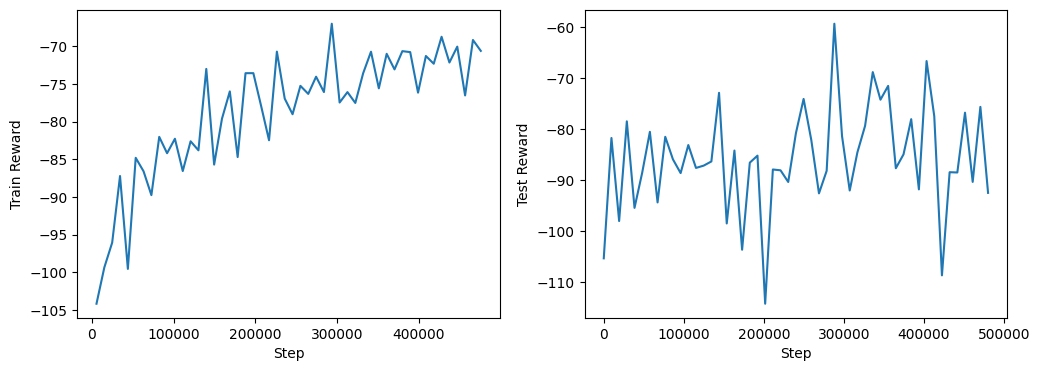

In [441]:
# plot train reward and test reward against number of steps
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_reward.loc[:, "Step"].tolist(), train_reward.loc[:, "Value"].tolist())
plt.xlabel("Step")
plt.ylabel("Train Reward")
plt.subplot(1, 2, 2)
plt.plot(test_reward.loc[:, "Step"].tolist(), test_reward.loc[:, "Value"].tolist())
plt.xlabel("Step")
plt.ylabel("Test Reward")
plt.show()

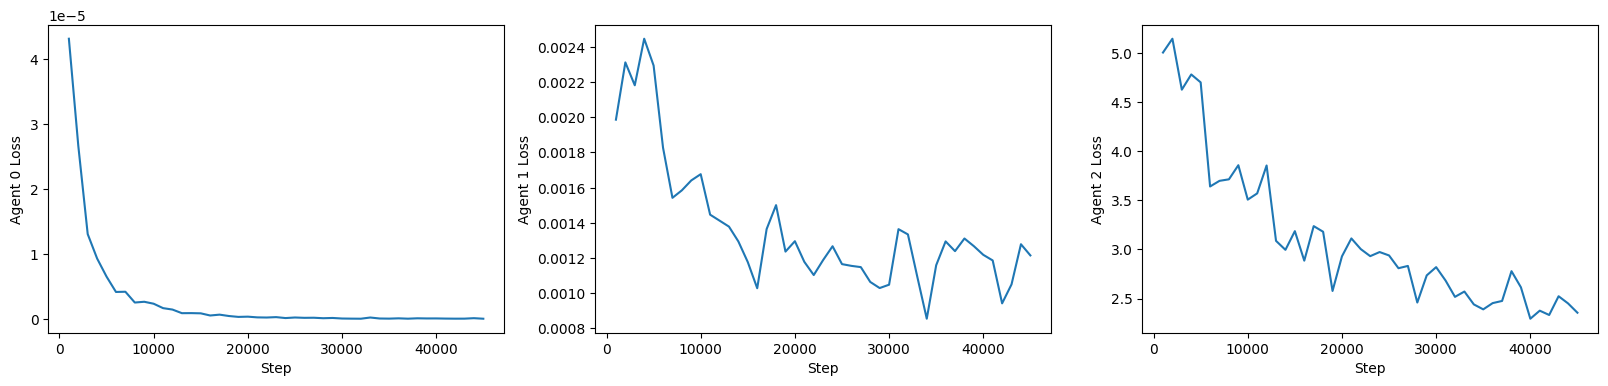

In [434]:
# plot agent loss against number of steps
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.plot(agent0_loss.loc[:, "Step"].tolist(), agent0_loss.loc[:, "Value"].tolist())
plt.xlabel("Step")
plt.ylabel("Agent 0 Loss")
plt.subplot(1, 3, 2)
plt.plot(agent1_loss.loc[:, "Step"].tolist(), agent1_loss.loc[:, "Value"].tolist())
plt.xlabel("Step")
plt.ylabel("Agent 1 Loss")
plt.subplot(1, 3, 3)
plt.plot(agent2_loss.loc[:, "Step"].tolist(), agent2_loss.loc[:, "Value"].tolist())
plt.xlabel("Step")
plt.ylabel("Agent 2 Loss")
plt.show()